<a href="https://colab.research.google.com/github/rishesh-g/Particle-Swarm-/blob/main/_Optimization_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
import pandas_datareader as pdr
import datetime

In [ ]:
from __future__ import division
import random
import math
import time

In [ ]:
!pip install pyswarm

  Created wheel for pyswarm: filename=pyswarm-0.6-cp36-none-any.whl size=4481 sha256=367b9591302efcd1275b565d61b50bff708a18f8a84f6cf270c493fc69cb1631
  Stored in directory: /root/.cache/pip/wheels/37/c5/f6/b33b9ac00040cb95c1f00af982a4197334a672d6de43f4699f
Successfully built pyswarm


In [ ]:
from pyswarm import pso
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit

# Get Data

In [ ]:
com = 'Apple'
share = 'AAPL'
start = '2016-01-01'

In [ ]:
dat = pdr.get_data_yahoo(share,start = start)

In [ ]:
dat

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,26.342501,25.500000,25.652500,26.337500,270597600.0,24.443037
2016-01-05,26.462500,25.602501,26.437500,25.677500,223164000.0,23.830513
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0,23.364161
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0,22.378082
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0,22.496408
...,...,...,...,...,...,...
2020-10-06,116.120003,112.250000,115.699997,113.160004,161498200.0,113.160004
2020-10-07,115.550003,114.129997,114.620003,115.080002,96849000.0,115.080002
2020-10-08,116.400002,114.589996,116.250000,114.970001,83477200.0,114.970001


# Features

In [ ]:
def typical(high,low,close,volume):
    mf = ((high + low + close)/3)*volume
    return mf     

In [ ]:
#EMA
def EMA(data):
    dats = data.astype(float)
    data['EMA'] = dats.ewm(span = 20).mean()
    return data['EMA']

In [ ]:
def MFI(data):
    returns = data - data.shift(1)
    returns.dropna()
    up,down = returns.copy(),returns.copy()
    up[up<0] = 0
    down[down>0] = 0
    upm = up.mean()
    downm = down.abs().mean()
    
    try:
      mfi = 100 - (100/(1+float(upm/downm)))
      return mfi
    except ZeroDivisionError:
      return 0

In [ ]:
#RSI
def RSI(data):
    returns = data - data.shift(1)
    returns.dropna()
    up,down = returns.copy(),returns.copy()
    up[up<0] = 0
    down[down>0] = 0
    upm = up.mean()
    downm = down.abs().mean()
    try:
      rsi = 100 - (100/(1+float(upm/downm)))
      return rsi
    except ZeroDivisionError:
      return 0 

In [ ]:
def MACD(ema):
    high = 0.075 * ema
    low = 0.15 * ema
    macd = high - low
    return macd

In [ ]:
def Oscillator(data):
    curr = data[-1]
    data = list(data)
    high = max(data)
    low = min(data)
    so = ((curr - low)/(high - low))*100 
    return so

In [ ]:
dat['MF'] = typical(dat['High'],dat['Low'],dat['Close'],dat['Volume'])

In [ ]:
dat

,High,Low,Open,Close,Volume,Adj Close,MF
Date,,,,,,,
2016-01-04,26.342501,25.500000,25.652500,26.337500,270597600.0,24.443037,7.051773e+09
2016-01-05,26.462500,25.602501,26.437500,25.677500,223164000.0,23.830513,5.783109e+09
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0,23.364161,6.912828e+09
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0,22.378082,7.920490e+09
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0,22.496408,6.910593e+09
...,...,...,...,...,...,...,...
2020-10-06,116.120003,112.250000,115.699997,113.160004,161498200.0,113.160004,1.838549e+10
2020-10-07,115.550003,114.129997,114.620003,115.080002,96849000.0,115.080002,1.112989e+10
2020-10-08,116.400002,114.589996,116.250000,114.970001,83477200.0,114.970001,9.626591e+09


In [ ]:
dat['EMA'] = EMA(dat.iloc[:,[3]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
dat['RSI'] = dat['Close'].rolling(7).apply(RSI)

In [ ]:
dat['MFI'] = dat['MF'].rolling(7).apply(MFI)

In [ ]:
dat['SO'] = dat['Close'].rolling(7).apply(Oscillator)

In [ ]:
dat

,High,Low,Open,Close,Volume,Adj Close,MF,EMA,RSI,MFI,SO
Date,,,,,,,,,,,
2016-01-04,26.342501,25.500000,25.652500,26.337500,270597600.0,24.443037,7.051773e+09,26.337500,NaN,NaN,NaN
2016-01-05,26.462500,25.602501,26.437500,25.677500,223164000.0,23.830513,5.783109e+09,25.991000,NaN,NaN,NaN
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0,23.364161,6.912828e+09,25.691369,NaN,NaN,NaN
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0,22.378082,7.920490e+09,25.235574,NaN,NaN,NaN
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0,22.496408,6.910593e+09,24.994753,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-06,116.120003,112.250000,115.699997,113.160004,161498200.0,113.160004,1.838549e+10,114.136023,43.644089,55.167786,3.713710
2020-10-07,115.550003,114.129997,114.620003,115.080002,96849000.0,115.080002,1.112989e+10,114.225926,53.254454,49.592418,54.641986
2020-10-08,116.400002,114.589996,116.250000,114.970001,83477200.0,114.970001,9.626591e+09,114.296790,46.911780,36.174882,51.724201


In [ ]:
dat['MACD'] = MACD(dat.iloc[:,[7]])

In [ ]:
dat['MACD_Signal'] = MACD(dat.iloc[:,[11]])

In [ ]:
copy_dat = dat.copy()

In [ ]:
#dat = copy_dat.copy()

In [ ]:
dat.drop(['Adj Close','MF','MACD_Signal'],axis = 1,inplace = True)

In [ ]:
dat

,High,Low,Open,Close,Volume,EMA,RSI,MFI,SO,MACD
Date,,,,,,,,,,
2016-01-04,26.342501,25.500000,25.652500,26.337500,270597600.0,26.337500,NaN,NaN,NaN,-1.975312
2016-01-05,26.462500,25.602501,26.437500,25.677500,223164000.0,25.991000,NaN,NaN,NaN,-1.949325
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0,25.691369,NaN,NaN,NaN,-1.926853
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0,25.235574,NaN,NaN,NaN,-1.892668
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0,24.994753,NaN,NaN,NaN,-1.874606
...,...,...,...,...,...,...,...,...,...,...
2020-10-06,116.120003,112.250000,115.699997,113.160004,161498200.0,114.136023,43.644089,55.167786,3.713710,-8.560202
2020-10-07,115.550003,114.129997,114.620003,115.080002,96849000.0,114.225926,53.254454,49.592418,54.641986,-8.566944
2020-10-08,116.400002,114.589996,116.250000,114.970001,83477200.0,114.296790,46.911780,36.174882,51.724201,-8.572259


# Pre-process

In [ ]:
xdata = dat.dropna()

In [ ]:
ydata = pd.DataFrame(xdata['Close'].shift(-7))

In [ ]:
#xdata = xdata.drop('Close',axis = 1)

In [ ]:
xcols = xdata.columns
xdates = xdata.index

ycols = ydata.columns
ydates = ydata.index

In [ ]:
from sklearn.preprocessing import StandardScaler
xscaler = StandardScaler()
yscaler = StandardScaler()
xdata = pd.DataFrame(xscaler.fit_transform(xdata))
ydata = pd.DataFrame(yscaler.fit_transform(ydata))

In [ ]:
xdata.columns = xcols
xdata.index = xdates

ydata.columns = ycols
ydata.index = ydates

In [ ]:
x_trains, y_trains = xdata[:900],ydata[:900]

In [ ]:
y_trains = pd.DataFrame(y_trains)

In [ ]:
x_tests, y_tests = xdata[900:],ydata[900:]

In [ ]:
y_tests = pd.DataFrame(y_tests)

In [ ]:
y_tests.dropna(inplace = True)

In [ ]:
y_tests

,Close
Date,
2019-08-09,0.296374
2019-08-12,0.326500
2019-08-13,0.324122
2019-08-14,0.194370
2019-08-15,0.245240
...,...
2020-08-12,4.090096
2020-08-13,4.168714
2020-08-14,4.114144


In [ ]:
x_tests

,High,Low,Open,Close,Volume,EMA,RSI,MFI,SO,MACD
Date,,,,,,,,,,
2019-08-09,0.178332,0.186242,0.187718,0.179505,-0.561139,0.262674,-0.749950,-1.861220,-0.285930,-0.262674
2019-08-12,0.169075,0.184363,0.165466,0.172774,-0.700744,0.259131,-0.519080,-1.479709,0.128713,-0.259131
2019-08-13,0.300639,0.202213,0.184009,0.284814,0.909813,0.267280,1.162948,-0.079270,0.979305,-0.267280
2019-08-14,0.226316,0.230530,0.212353,0.202731,0.215233,0.266335,0.226469,0.160793,-0.354169,-0.266335
2019-08-15,0.209366,0.191342,0.216327,0.189402,-0.391404,0.264129,-0.007233,-0.242345,-0.889124,-0.264129
...,...,...,...,...,...,...,...,...,...,...
2020-08-21,4.047169,3.913305,3.839975,4.092176,3.337352,3.636675,1.537408,1.185895,0.979305,-3.636675
2020-08-24,4.251492,4.164943,4.339834,4.170695,3.465624,3.716960,1.589770,1.793052,0.979305,-3.716960
2020-08-25,4.063468,4.117434,4.127917,4.116193,1.277922,3.784076,1.366494,0.729775,0.743785,-3.784076


In [ ]:
x_tests  = x_tests[:-7]

In [ ]:
xdata  = xdata[:-7]

In [ ]:
ydata.dropna(inplace = True)

In [ ]:
x_tests

,High,Low,Open,Close,Volume,EMA,RSI,MFI,SO,MACD
Date,,,,,,,,,,
2019-08-09,0.178332,0.186242,0.187718,0.179505,-0.561139,0.262674,-0.749950,-1.861220,-0.285930,-0.262674
2019-08-12,0.169075,0.184363,0.165466,0.172774,-0.700744,0.259131,-0.519080,-1.479709,0.128713,-0.259131
2019-08-13,0.300639,0.202213,0.184009,0.284814,0.909813,0.267280,1.162948,-0.079270,0.979305,-0.267280
2019-08-14,0.226316,0.230530,0.212353,0.202731,0.215233,0.266335,0.226469,0.160793,-0.354169,-0.266335
2019-08-15,0.209366,0.191342,0.216327,0.189402,-0.391404,0.264129,-0.007233,-0.242345,-0.889124,-0.264129
...,...,...,...,...,...,...,...,...,...,...
2020-08-12,3.442545,3.432710,3.375612,3.492520,0.536699,3.259773,0.179044,-0.009709,0.473439,-3.259773
2020-08-13,3.586888,3.627578,3.583953,3.598093,1.254920,3.317925,0.319516,1.464752,0.979305,-3.317925
2020-08-14,3.532515,3.580203,3.605144,3.592683,0.530522,3.369990,-0.089132,-0.595792,0.932626,-3.369990


In [ ]:
y_tests

,Close
Date,
2019-08-09,0.296374
2019-08-12,0.326500
2019-08-13,0.324122
2019-08-14,0.194370
2019-08-15,0.245240
...,...
2020-08-12,4.090096
2020-08-13,4.168714
2020-08-14,4.114144


In [ ]:
x_tests

,High,Low,Open,Close,Volume,EMA,RSI,MFI,SO,MACD
Date,,,,,,,,,,
2019-08-09,0.178332,0.186242,0.187718,0.179505,-0.561139,0.262674,-0.749950,-1.861220,-0.285930,-0.262674
2019-08-12,0.169075,0.184363,0.165466,0.172774,-0.700744,0.259131,-0.519080,-1.479709,0.128713,-0.259131
2019-08-13,0.300639,0.202213,0.184009,0.284814,0.909813,0.267280,1.162948,-0.079270,0.979305,-0.267280
2019-08-14,0.226316,0.230530,0.212353,0.202731,0.215233,0.266335,0.226469,0.160793,-0.354169,-0.266335
2019-08-15,0.209366,0.191342,0.216327,0.189402,-0.391404,0.264129,-0.007233,-0.242345,-0.889124,-0.264129
...,...,...,...,...,...,...,...,...,...,...
2020-08-12,3.442545,3.432710,3.375612,3.492520,0.536699,3.259773,0.179044,-0.009709,0.473439,-3.259773
2020-08-13,3.586888,3.627578,3.583953,3.598093,1.254920,3.317925,0.319516,1.464752,0.979305,-3.317925
2020-08-14,3.532515,3.580203,3.605144,3.592683,0.530522,3.369990,-0.089132,-0.595792,0.932626,-3.369990


In [ ]:
y_trains

,Close
Date,
2016-01-12,-1.143052
2016-01-13,-1.169214
2016-01-14,-1.161947
2016-01-15,-1.248756
2016-01-19,-1.239903
...,...
2019-08-02,0.278008
2019-08-05,0.195823
2019-08-06,0.182478


# LSSVR

In [ ]:
#basewoa 20p 30e for at and t

"""Least Squares Support Vector Regression."""
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.gaussian_process import kernels
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from scipy.sparse import linalg


class LSSVR1(BaseEstimator, RegressorMixin):
    def __init__(self, C=None, kernel=None, gamma=None):
        self.supportVectors      = None
        self.supportVectorLabels = None
        self.C = C
        self.gamma = gamma
        self.kernel= kernel
        self.idxs  = None
        self.K = None
        self.bias = None 
        self.alphas = None
            

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, x_train, y_train):
        
        if type(self.idxs) == type(None):
            self.idxs=np.full(x_train.shape[0],True, dtype=bool)
            
             
        self.supportVectors      = x_train.loc[self.idxs, :]
        self.supportVectorLabels = y_train.loc[self.idxs]
               
        K = self.kernel_func(self.kernel, x_train, self.supportVectors, self.gamma)
        
        self.K = K
        OMEGA = K
        OMEGA[self.idxs, np.arange(OMEGA.shape[1])] =OMEGA[self.idxs, np.arange(OMEGA.shape[1])] + 1/self.C
        
        D = np.zeros(np.array(OMEGA.shape) + 1)
        
        D[1:,1:] = OMEGA
        D[0, 1:] += 1
        D[1:,0 ] += 1

        n = len(self.supportVectorLabels) + 1
        t = np.zeros(n)
        t = pd.DataFrame(t)
        t[1:n] = self.supportVectorLabels.values
    
        try:
            z = linalg.lsmr(D.T, t)[0]
        except:
            z = np.linalg.pinv(D).T @ t.ravel()

        self.bias   = z[0]
        self.alphas = z[1:]
        self.alphas = self.alphas[self.idxs]

        return self

    def predict(self, x_test):
        K = self.kernel_func(self.kernel, x_test, self.supportVectors, self.gamma)

        return (K @ self.alphas) + self.bias

    def kernel_func(self, kernel, u, v, gamma):
        if kernel == 'linear':
            k = np.dot(u, v.T)
        if kernel == 'rbf':
            k = rbf_kernel(u, v, gamma=gamma)
        return k

In [ ]:
"""Least Squares Support Vector Regression."""
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.gaussian_process import kernels
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from scipy.sparse import linalg


class LSSVR(BaseEstimator, RegressorMixin):
    def __init__(self, C=None, kernel=None, gamma=None):
        self.supportVectors      = None
        self.supportVectorLabels = None
        self.C = C
        self.gamma = gamma
        self.kernel= kernel
        self.idxs  = None
        self.K = None
        self.bias = None 
        self.alphas = None
            

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, x_train, y_train):
        
        if type(self.idxs) == type(None):
            self.idxs=np.full(x_train.shape[0],True, dtype=bool)
            
             
        self.supportVectors      = x_train.loc[self.idxs, :]
        self.supportVectorLabels = y_train.loc[self.idxs]
               
        K = self.kernel_func(self.kernel, x_train, self.supportVectors, self.gamma)
        
        self.K = K
        OMEGA = K
        OMEGA[self.idxs, np.arange(OMEGA.shape[1])] =OMEGA[self.idxs, np.arange(OMEGA.shape[1])] + 1/self.C
        
        D = np.zeros(np.array(OMEGA.shape) + 1)
        
        D[1:,1:] = OMEGA
        D[0, 1:] += 1
        D[1:,0 ] += 1

        n = len(self.supportVectorLabels) + 1
        t = np.zeros(n)
        
        t[1:n] = self.supportVectorLabels
    
        try:
            z = linalg.lsmr(D.T, t)[0]
        except:
            z = np.linalg.pinv(D).T @ t.ravel()

        self.bias   = z[0]
        self.alphas = z[1:]
        self.alphas = self.alphas[self.idxs]

        return self

    def predict(self, x_test):
        K = self.kernel_func(self.kernel, x_test, self.supportVectors, self.gamma)

        return (K @ self.alphas) + self.bias
    
    def kernel_func(self, kernel, u, v, gamma):
        if kernel == 'linear':
            k = np.dot(u, v.T)
        if kernel == 'rbf':
            k = rbf_kernel(u, v, gamma=gamma)
            
        return k

# Optimizers

In [ ]:
class salp:
    def __init__(self,bounds):
        self.position = []
        self.fitness = -1

        for i in range(0,n_dim):
            self.position.append(random.uniform(bounds[i][0],bounds[i][1]))
    
    def evaluate(self,costFunc):
        self.fitness = costFunc(self.position)
        
    def update_leader(self,F,c1,bounds):
        for i in range(0,n_dim):
            c2 = random.random()
            c3 = random.random()
            
            if c3 >=0.5:
                self.position[i] = F[i] + c1*(c2*(bounds[i][1] - bounds[i][0]) + bounds[i][0])
            elif c3<0.5:
                self.position[i] = F[i] - c1*(c2*(bounds[i][1] - bounds[i][0]) + bounds[i][0])
                
            if self.position[i]>bounds[i][1]:
                self.position[i]=bounds[i][1]

            if self.position[i] < bounds[i][0]:
                self.position[i]=bounds[i][0] 
                
                     
                
class SSA():
    def __init__(self,bounds):
        global n_dim
        #print ('Without local search ')
        
        n_dim = len(bounds)
        self.F_pos = []
        self.F_val = -1
        
    def optimize(self,costFunc,bounds,salp_size,maxiter):
      self.salps = []
      for i in range(0,salp_size):
          self.salps.append(salp(bounds))
            
      i = 0
      while i < maxiter:
            
          c1 = 2*math.exp(-((4*i)/maxiter)**2)
            
          for j in range(0,salp_size):
              self.salps[j].evaluate(costFunc)
              if self.salps[j].fitness <self.F_val or self.F_val == -1:
                  self.F_val = self.salps[j].fitness
                  self.F_pos = list(self.salps[j].position)
            
          for j in range(0,salp_size):        
              if j == 1:
                  self.salps[j].update_leader(self.F_pos,c1,bounds)
              else :
                  for k in range(0,n_dim):
                      self.salps[j].position[k] = (self.salps[j].position[k] + self.salps[j-1].position[k])/2
                      if self.salps[j].position[k]>bounds[k][1]:
                          self.salps[j].position[k]=bounds[k][1]

                      if self.salps[j].position[k] < bounds[k][0]:
                          self.salps[j].position[k]=bounds[k][0]    
          i = i+1 
            
      #print ('Pos - ',self.F_pos)
      #print ('Optimum - ',self.F_val)
      return self.F_pos,self.F_val   

In [ ]:
import numpy
class salp1:

    def __init__(self,bounds):
        self.position = []
        self.fitness = -1

        for i in range(0,n_dim):
            self.position.append(random.uniform(bounds[i][0],bounds[i][1]))
    
    def evaluate(self,costFunc):
        self.fitness = costFunc(self.position)

    def fit(self,costFunc,thisone):
        return costFunc(thisone)
        
    def update_leader(self,F,c1,bounds):
        for i in range(0,n_dim):
            c2 = random.random()
            c3 = random.random()
            
            if c3 >=0.5:
                self.position[i] = F[i] + c1*(c2*(bounds[i][1] - bounds[i][0]) + bounds[i][0])
            elif c3<0.5:
                self.position[i] = F[i] - c1*(c2*(bounds[i][1] - bounds[i][0]) + bounds[i][0])
                
            if self.position[i]>bounds[i][1]:
                self.position[i]=bounds[i][1]

            if self.position[i] < bounds[i][0]:
                self.position[i]=bounds[i][0]

    def randomwalk(self,agent,n):
      percent = 30
      percent /= 100
      neighbor = agent.copy()
      size = np.shape(neighbor)[0]
      #print (size)
      upper = int(percent*size)
      if upper <= 1:
          upper = size
      x = random.randint(1,upper)
      #print ('x - ',x)
      pos = random.sample(range(0,size),x)
      #print ('pos generated - ',pos)
      for i in pos:
          if random.random() < 0.5:
            neighbor[i] = neighbor[i] + n
          else :
            neighbor[i] = neighbor[i] - n
      return neighbor


    def adaptiveBeta(self,costFunc,k,bounds):
        #print ('entry - ',self.position)

        bmin = 0.1 #parameter: (can be made 0.01)
        bmax = 1
        maxIter = 7 # parameter: (can be increased )
        pow = 1/k
        
        agentFit = self.fitness
        agent = np.asarray_chkfinite(self.position.copy())
        for curr in range(maxIter):
            neighbor = agent.copy()
            n = 1 - float((curr**pow)/(maxIter**pow))
            #print ('n - ',n)
            
https://colab.research.google.com/drive/1SLTc8c825fLQJZxojAZV9h7OZArAE0tG?usp=sharing
            #print (neighbor)
            size = np.shape(neighbor)[0]
            #print ('size - ',np.shape(neighbor))
            neighbor = self.randomwalk(neighbor,n)

            beta = bmin + (curr / maxIter)*(bmax - bmin)
            #print ('beta - ',beta)
            for i in range(size):
                random.seed( time.time() + i )
                if random.random() <= beta:
                    neighbor[i] = agent[i]
                    #print (neighbor[i])
                    
                    neighbor[i] = numpy.clip(neighbor[i],bounds[i][0],bounds[i][1])
                    #print (neighbor[i])
            neighbor = numpy.clip(neighbor,bounds[0][0],bounds[0][1])
            neighFit = self.fit(costFunc,neighbor)
            #print (neighFit)
            if neighFit <= agentFit:
                agent = neighbor.copy()
                agentFit = neighFit

            
            '''if list(agent) != self.position:
              print ('better solution found')
              
            else:
              print ('previous was better')'''

        #print ('After hill climbing - ',agent)
        #print ('\n')
        self.position = agent
        self.fitness = agentFit
         
                        
class SSA1():
    def __init__(self,bounds):
        global n_dim
        #print ('With local search ')
        
        n_dim = len(bounds)
        self.F_pos = []
        self.F_val = -1
        
    def optimize(self,costFunc,bounds,salp_size,maxiter):
      self.salps = []
      for i in range(0,salp_size):
          self.salps.append(salp1(bounds))
            
      i = 0
      while i < maxiter:
            
          c1 = 2*math.exp(-((4*i)/maxiter)**2)
            
          for j in range(0,salp_size):
              self.salps[j].evaluate(costFunc)
              if self.salps[j].fitness <self.F_val or self.F_val == -1:
                  self.F_val = self.salps[j].fitness
                  self.F_pos = list(self.salps[j].position)
              #self.salps[j].adaptiveBeta(costFunc,30,bounds)
            
          for j in range(0,salp_size):        
              if j == 1:
                  self.salps[j].update_leader(self.F_pos,c1,bounds)
                  self.salps[j].adaptiveBeta(costFunc,30,bounds)
              else :
                  for k in range(0,n_dim):
                      self.salps[j].position[k] = (self.salps[j].position[k] + self.salps[j-1].position[k])/2
                      if self.salps[j].position[k]>bounds[k][1]:
                          self.salps[j].position[k]=bounds[k][1]

                      if self.salps[j].position[k] < bounds[k][0]:
                          self.salps[j].position[k]=bounds[k][0]    
          i = i+1 
            
      #print ('Pos - ',self.F_pos)
      #print ('Optimum - ',self.F_val)
      return self.F_pos,self.F_val   
            

In [ ]:
import random
import numpy
import math
import time

def HHO(objf,lb,ub,dim,SearchAgents_no,Max_iter):
    #print ('Without Local Search')


    # initialize the location and Energy of the rabbit
    Rabbit_Location=numpy.zeros(dim)
    Rabbit_Energy=float("inf")  #change this to -inf for maximization problems
    best_energy=float("inf")
    best_location=0
    
    #Initialize the locations of Harris' hawks
    X=numpy.random.uniform(0,1,(SearchAgents_no,dim)) *(ub-lb)+lb
    
    #Initialize convergence
    convergence_curve=numpy.zeros(Max_iter)
    
    
    ############################

    #print("HHO is now tackling  \""+objf.__name__+"\"")    

    timerStart=time.time() 
    ############################
    
    t=0  # Loop counter
    
    # Main loop
    while t<Max_iter:
        for i in range(0,SearchAgents_no):
            
            # Check boundries
                      
            X[i,:]=numpy.clip(X[i,:], lb, ub)
            
            # fitness of locations
            fitness=objf(X[i,:])
            
            # Update the location of Rabbit
            if fitness<Rabbit_Energy: # Change this to > for maximization problem
                Rabbit_Energy=fitness 
                Rabbit_Location=X[i,:].copy() 
            
        E1=2*(1-(t/Max_iter)) # factor to show the decreaing energy of rabbit    
        
        # Update the location of Harris' hawks xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssc                                                          eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee44444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444
        for i in range(0,SearchAgents_no):

            E0=2*random.random()-1;  # -1<E0<1
            Escaping_Energy=E1*(E0)  # escaping energy of rabbit Eq. (3) in the paper

            # -------- Exploration phase Eq. (1) in paper -------------------

            if abs(Escaping_Energy)>=1:
                #Harris' hawks perch randomly based on 2 strategy:
                q = random.random()
                rand_Hawk_index = math.floor(SearchAgents_no*random.random())
                X_rand = X[rand_Hawk_index, :]
                if q<0.5:
                    # perch based on other family members
                    X[i,:]=X_rand-random.random()*abs(X_rand-2*random.random()*X[i,:])

                elif q>=0.5:
                    #perch on a random tall tree (random site inside group's home range)
                    X[i,:]=(Rabbit_Location - X.mean(0))-random.random()*((ub-lb)*random.random()+lb)

            # -------- Exploitation phase -------------------
            elif abs(Escaping_Energy)<1:
                #Attacking the rabbit using 4 strategies regarding the behavior of the rabbit

                #phase 1: ----- surprise pounce (seven kills) ----------
                #surprise pounce (seven kills): multiple, short rapid dives by different hawks

                r=random.random() # probablity of each event
                
                if r>=0.5 and abs(Escaping_Energy)<0.5: # Hard besiege Eq. (6) in paper
                    X[i,:]=(Rabbit_Location)-Escaping_Energy*abs(Rabbit_Location-X[i,:])
                    #print ('Hard besiege')

                if r>=0.5 and abs(Escaping_Energy)>=0.5:  # Soft besiege Eq. (4) in paper
                    Jump_strength=2*(1- random.random()); # random jump strength of the rabbit
                    X[i,:]=(Rabbit_Location-X[i,:])-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X[i,:])
                    #print ('Soft besiege')

                #phase 2: --------performing team rapid dives (leapfrog movements)----------

                if r<0.5 and abs(Escaping_Energy)>=0.5: # Soft besiege Eq. (10) in paper
                    #rabbit try to escape by many zigzag deceptive motions
                    Jump_strength=2*(1-random.random())
                    X1=Rabbit_Location-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X[i,:]);
                    #print ('Soft besiege with rapid dives')

                    if objf(X1)< fitness: # improved move?
                        X[i,:] = X1.copy()
                    else: # hawks perform levy-based short rapid dives around the rabbit
                        X2=Rabbit_Location-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X[i,:])+numpy.multiply(numpy.random.randn(dim),Levy(dim))
                        if objf(X2)< fitness:
                            X[i,:] = X2.copy()
                            #print ('levy based soft besiege with rapid dives')
                if r<0.5 and abs(Escaping_Energy)<0.5:   # Hard besiege Eq. (11) in paper
                    Jump_strength=2*(1-random.random())
                    X1=Rabbit_Location-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X.mean(0))
                    #print ('Hard besiege with rapid dives')
         
                    if objf(X1)< fitness: # improved move?
                        X[i,:] = X1.copy()
                    else: # Perform levy-based short rapid dives around the rabbit
                        X2=Rabbit_Location-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X.mean(0))+numpy.multiply(numpy.random.randn(dim),Levy(dim))
                        if objf(X2)< fitness:
                            X[i,:] = X2.copy()
                            #print ('levy based Hard besiege with rapid dives')
                
        convergence_curve[t]=Rabbit_Energy
        if (Rabbit_Energy<=best_energy):
            best_energy=Rabbit_Energy
            best_location=Rabbit_Location
        '''if (t%1==0):
               print(['At iteration '+ str(t)+ ' the best fitness is '+ str(Rabbit_Energy)])'''
        t=t+1
    
    timerEnd=time.time()
    
    #print("The best location is", best_location)
    #print("The best energy is", best_energy)

    return best_location,best_energy
    

    

def Levy(dim):
    beta=1.5
    sigma=(math.gamma(1+beta)*math.sin(math.pi*beta/2)/(math.gamma((1+beta)/2)*beta*2**((beta-1)/2)))**(1/beta) 
    #print ('I was used')
    u= 0.01*numpy.random.randn(dim)*sigma
    v = numpy.random.randn(dim)
    zz = numpy.power(numpy.absolute(v),(1/beta))
    step = numpy.divide(u,zz)
    return step

In [ ]:
class RootAlgo(object):
    """ This is root of all Algorithms """
    ID_MIN_PROBLEM = 0
    ID_MAX_PROBLEM = -1

    def __init__(self, root_algo_paras = None):
        self.problem_size = root_algo_paras["problem_size"]
        self.domain_range = root_algo_paras["domain_range"]
        self.print_train = root_algo_paras["print_train"]
        self.objective_func = root_algo_paras["objective_func"]
        self.solution, self.loss_train = None, []

    def _create_solution__(self, minmax=0):
        solution = np.random.uniform(self.domain_range[0], self.domain_range[1], self.problem_size)
        fitness = self._fitness_model__(solution=solution, minmax=minmax)
        return [solution, fitness]

    def _fitness_model__(self, solution=None, minmax=0):
        """ Assumption that objective function always return the original value """
        return self.objective_func(solution, self.problem_size) if minmax == 0 \
            else 1.0 / self.objective_func(solution, self.problem_size)

    def _fitness_encoded__(self, encoded=None, id_pos=None, minmax=0):
        return self._fitness_model__(solution=encoded[id_pos], minmax=minmax)

    def _get_global_best__(self, pop=None, id_fitness=None, id_best=None):
        sorted_pop = sorted(pop, key=lambda temp: temp[id_fitness])
        return deepcopy(sorted_pop[id_best])

    def _get_global_worst__(self, pop=None, id_fitness=None, id_worst=None):
        sorted_pop = sorted(pop, key=lambda temp: temp[id_fitness])
        return deepcopy(sorted_pop[id_worst])

    def _amend_solution__(self, solution=None):
        for i in range(self.problem_size):
            if solution[i] < self.domain_range[0]:
                solution[i] = self.domain_range[0]
            if solution[i] > self.domain_range[1]:
                solution[i] = self.domain_range[1]

    def _amend_solution_and_return__(self, solution=None):
        for i in range(self.problem_size):
            if solution[i] < self.domain_range[0]:
                solution[i] = self.domain_range[0]
            if solution[i] > self.domain_range[1]:
                solution[i] = self.domain_range[1]
        return solution

    ### This is failed version
    # def _amend_solution_and_return_failed__(self, solution=None):
    #     temp = deepcopy(solution)
    #     for i in range(self.problem_size):
    #         if solution[i] < self.domain_range[0]:
    #             solution[i] = self.domain_range[0]
    #         if solution[i] > self.domain_range[1]:
    #             solution[i] = self.domain_range[1]
    #     return temp


    def _create_opposition_solution__(self, solution=None, g_best=None):
        temp = [self.domain_range[0] + self.domain_range[1] - g_best[i] + np.random.random() * (g_best[i] - solution[i])
                      for i in range(self.problem_size)]
        return np.array(temp)


    def _train__(self):
        pass

In [ ]:
from copy import deepcopy
import numpy as np
from math import gamma

class BaseHHO(RootAlgo):
    """
    Harris Hawks Optimization: Algorithm and Applications
    """
    ID_POS = 0
    ID_FIT = 1

    def __init__(self, root_algo_paras=None, hho_paras=None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = hho_paras["epoch"]
        self.pop_size = hho_paras["pop_size"]

    def _train__(self):
        pop = [self._create_solution__() for _ in range(0, self.pop_size)]
        gbest = self._get_global_best__(pop, self.ID_FIT, self.ID_MIN_PROBLEM)
        for epoch in range(0, self.epoch):

            # Update the location of Harris' hawks
            for i in range(0, self.pop_size):
                E0 = 2 * np.random.uniform() - 1                        # -1 < E0 < 1
                E = 2 * E0 * (1 - (epoch + 1) * 1.0 / self.epoch)       # factor to show the decreasing energy of rabbit
                J = 2 * (1 - np.random.uniform())

                # -------- Exploration phase Eq. (1) in paper -------------------
                if (np.abs(E) >= 1):
                    # Harris' hawks perch randomly based on 2 strategy:
                    if (np.random.uniform() >= 0.5):        # perch based on other family members
                        X_rand = deepcopy(pop[np.random.randint(0, self.pop_size)][self.ID_POS])
                        pop[i][self.ID_POS] = X_rand - np.random.uniform() * np.abs(X_rand - 2 * np.random.uniform() * pop[i][self.ID_POS])

                    else:           # perch on a random tall tree (random site inside group's home range)
                        X_m = np.mean([x[self.ID_POS] for x in pop])
                        pop[i][self.ID_POS] = (gbest[self.ID_POS] - X_m) - np.random.uniform()*(
                            self.domain_range[0] + np.random.uniform() * (self.domain_range[1] - self.domain_range[0]))

                # -------- Exploitation phase -------------------
                else:
                    # Attacking the rabbit using 4 strategies regarding the behavior of the rabbit
                    # phase 1: ----- surprise pounce (seven kills) ----------
                    # surprise pounce (seven kills): multiple, short rapid dives by different hawks
                    if (np.random.uniform() >= 0.5):
                        delta_X = gbest[self.ID_POS] - pop[i][self.ID_POS]
                        if (np.abs(E) >= 0.5):          # Hard besiege Eq. (6) in paper
                            pop[i][self.ID_POS] = delta_X - E * np.abs( J * gbest[self.ID_POS] - pop[i][self.ID_POS] )
                        else:                           # Soft besiege Eq. (4) in paper
                            pop[i][self.ID_POS] = gbest[self.ID_POS] - E * np.abs(delta_X)
                    else:
                        xichma = np.power((gamma(1 + 1.5) * np.sin(np.pi * 1.5 / 2.0)) / (gamma((1 + 1.5) * 1.5 * np.power(2, (1.5 - 1) / 2)) / 2.0), 1.0 / 1.5)
                        LF_D = 0.01 * np.random.uniform() * xichma / np.power(np.abs(np.random.uniform()), 1.0 / 1.5)
                        fit_Y, Y = None, None
                        if (np.abs(E) >= 0.5):      # Soft besiege Eq. (10) in paper
                            Y = gbest[self.ID_POS] - E * np.abs( J * gbest[self.ID_POS] - pop[i][self.ID_POS] )
                            fit_Y = self._fitness_model__(Y)
                        else:                       # Hard besiege Eq. (11) in paper
                            X_m = np.mean([x[self.ID_POS] for x in pop])
                            Y = gbest[self.ID_POS] - E * np.abs( J * gbest[self.ID_POS] - X_m )
                            fit_Y = self._fitness_model__(Y)

                        Z = Y + np.random.uniform(self.domain_range[0], self.domain_range[1], self.problem_size) * LF_D
                        fit_Z = self._fitness_model__(Z)

                        if fit_Y < pop[i][self.ID_FIT]:
                            pop[i] = [Y, fit_Y]
                        if fit_Z < pop[i][self.ID_FIT]:
                            pop[i] = [Z, fit_Z]

            current_best = self._get_global_best__(pop, self.ID_FIT, self.ID_MIN_PROBLEM)
            if current_best[self.ID_FIT] < gbest[self.ID_FIT]:
                gbest = deepcopy(current_best)
            self.loss_train.append(gbest[self.ID_FIT])
            if self.print_train:
                print("Epoch = {}, Fit = {}".format(epoch + 1, gbest[self.ID_FIT]))

        return gbest[self.ID_POS], gbest[self.ID_FIT]

In [ ]:
class BaseDE(RootAlgo):

    ID_SOl = 0
    ID_FIT = 1
    def __init__(self, root_algo_paras=None, de_paras = None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch =  de_paras["epoch"]
        self.pop_size = de_paras["pop_size"]
        self.weighting_factor = de_paras["Wf"]
        self.crossover_rate = de_paras["Cr"]

    def _mutation__(self, p0, p1, p2, p3):
        # Choose a cut point which differs 0 and chromosome-1 (first and last element)
        cut_point = np.random.randint(0, self.problem_size-1)
        sample = []
        for i in range(self.problem_size):
            if i == cut_point or np.random.uniform() < self.crossover_rate  :
                v = p1[i] + self.weighting_factor * ( p2[i] - p3[i])
                v = self.domain_range[0] if v < self.domain_range[0] else v
                v = self.domain_range[1] if v > self.domain_range[1] else v
                sample.append(v)
            else :
                sample.append(p0[i])
        return np.array(sample)

    def _create_children__(self, pop):
        new_children = []
        for i in range(self.pop_size):
            temp = np.random.choice(range(0, self.pop_size), 3, replace=False)
            while i in temp:
                temp = np.random.choice(range(0, self.pop_size), 3, replace=False)
            #create new child and append in children array
            child = self._mutation__(pop[i][self.ID_SOl], pop[temp[0]][self.ID_SOl], pop[temp[1]][self.ID_SOl], pop[temp[2]][self.ID_SOl])
            fit = self._fitness_model__(child)
            new_children.append([child, fit])
        return np.array(new_children)

    ### Survivor Selection
    def _greedy_selection__(self, pop_old=None, pop_new=None):
        pop = [pop_new[i] if pop_new[i][self.ID_FIT] < pop_old[i][self.ID_FIT]
               else pop_old[i] for i in range(self.pop_size)]
        return pop

    def _train__(self):
        pop = [self._create_solution__() for _ in range(self.pop_size)]
        gbest = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)

        for i in range(self.epoch):
            # create children
            children = self._create_children__(pop)
            # create new pop by comparing fitness of corresponding each member in pop and children
            pop = self._greedy_selection__(pop, children)

            current_best = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)
            if current_best[self.ID_FIT]< gbest[self.ID_FIT]:
                gbest = deepcopy(current_best)
            self.loss_train.append(gbest[self.ID_FIT])
            if self.print_train:
                print("Epoch : {}, [MSE, MAE]: {}".format(i + 1, gbest[self.ID_FIT]))

        return gbest[self.ID_SOl], gbest[self.ID_FIT]


In [ ]:
class BaseGA(RootAlgo):
    ID_FITNESS = 1

    def __init__(self, root_algo_paras=None, ga_paras = None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = ga_paras["epoch"]
        self.pop_size = ga_paras["pop_size"]
        self.pc = ga_paras["pc"]
        self.pm = ga_paras["pm"]

    ### Selection
    def _get_index_roulette_wheel_selection__(self, list_fitness, sum_fitness):
        r = np.random.uniform(low=0, high=sum_fitness)
        for idx, f in enumerate(list_fitness):
            r = r + f
            if r > sum_fitness:
                return idx

    ### Crossover
    def _crossover_arthmetic_recombination__(self, dad=None, mom=None):
        r = np.random.uniform()             # w1 = w2 when r =0.5
        w1 = np.multiply(r, dad) + np.multiply((1 - r), mom)
        w2 = np.multiply(r, mom) + np.multiply((1 - r), dad)
        return w1, w2

    ### Mutation
    def _mutation_flip_point__(self, parent, index):
        w = deepcopy(parent)
        w[index] = np.random.uniform(self.domain_range[0], self.domain_range[1])
        return w

    def _create_next_generation__(self, pop):
        next_population = []

        list_fitness = [pop[i][self.ID_FITNESS] for i in range(self.pop_size)]
        fitness_sum = sum(list_fitness)
        while (len(next_population) < self.pop_size):
            ### Selection
            c1 = deepcopy( pop[self._get_index_roulette_wheel_selection__(list_fitness, fitness_sum)] )
            c2 = deepcopy( pop[self._get_index_roulette_wheel_selection__(list_fitness, fitness_sum)] )

            w1, w2 = deepcopy(c1[0]), deepcopy(c2[0])
            ### Crossover
            if np.random.uniform() < self.pc:
                w1, w2 = self._crossover_arthmetic_recombination__(c1[0], c2[0])

            ### Mutation
            for id in range(0, self.problem_size):
                if np.random.uniform() < self.pm:
                    w1 = self._mutation_flip_point__(w1, id)
                if np.random.uniform() < self.pm:
                    w2 = self._mutation_flip_point__(w2, id)

            c1_new = [deepcopy(w1), self._fitness_model__(w1, minmax=1)]
            c2_new = [deepcopy(w2), self._fitness_model__(w2, minmax=1)]
            next_population.append(c1_new)
            next_population.append(c2_new)
        return next_population


    def _train__(self):
        best_train = [None, -1 ]
        pop = [self._create_solution__(minmax=1) for _ in range(self.pop_size)]

        for j in range(0, self.epoch):
            # Next generations
            pop = deepcopy(self._create_next_generation__(pop))
            current_best = self._get_global_best__(pop=pop, id_fitness=self.ID_FITNESS, id_best=self.ID_MAX_PROBLEM)
            if current_best[self.ID_FITNESS] > best_train[self.ID_FITNESS]:
                best_train = current_best
            if self.print_train:
                print("> Epoch {0}: Best training fitness {1}".format(j + 1, 1.0 / best_train[self.ID_FITNESS]))
            self.loss_train.append(np.power(best_train[self.ID_FITNESS], -1))

        return best_train[0], best_train[self.ID_FITNESS]

In [ ]:
import random

class BaseABC(RootAlgo):
 
    ID_BEE = 0
    ID_FITNESS = 1

    def __init__(self, root_algo_paras=None, abc_paras=None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = abc_paras["epoch"]
        self.pop_size = abc_paras["pop_size"]
        self.e_bees = abc_paras["couple_bees"][0]
        self.o_bees = abc_paras["couple_bees"][1]

        self.patch_size = abc_paras["patch_variables"][0]
        self.patch_factor = abc_paras["patch_variables"][1]
        self.num_sites = abc_paras["sites"][0]
        self.elite_sites = abc_paras["sites"][1]

    def _create_neigh_bee__(self, individual=None, patch_size=None):
        t1 = np.random.randint(0, len(individual) - 1)
        new_bee = deepcopy(individual)
        new_bee[t1] = (individual[t1] + random.random() * patch_size) if random.random() < 0.5 else (individual[t1] - random.random() * patch_size)
        if random.random() < 0.5:
            new_bee[t1] = individual[t1] + random.random() * patch_size
            if new_bee[t1] > self.domain_range[1]:
                new_bee[t1] = self.domain_range[1]
        else:
            new_bee[t1] = individual[t1] - random.random() * patch_size
            if new_bee[t1] < self.domain_range[0]:
                new_bee[t1] = self.domain_range[0]
        return [new_bee, self._fitness_model__(new_bee)]


    def _search_neigh__(self, parent=None, neigh_size=None):  # parent:  [ vector_individual, fitness ]
        """
        Seeking in neigh_size neighborhood, take the best
        """
        neigh = [self._create_neigh_bee__(parent[0], self.patch_size) for _ in range(0, neigh_size)]
        return self._get_global_best__(neigh, self.ID_FITNESS, self.ID_MIN_PROBLEM)

    def _create_scout_bees__(self, num_scouts=None):  # So luong ong trinh tham
        return [self._create_solution__() for _ in range(0, num_scouts)]

    def _train__(self):
        pop = [self._create_solution__() for _ in range(0, self.pop_size)]
        for j in range(0, self.epoch):
            pop_sorted = sorted(pop, key=lambda bee: bee[self.ID_FITNESS])
            best = deepcopy(pop_sorted[self.ID_MIN_PROBLEM])

            next_gen = []
            for i in range(0, self.num_sites):
                if i < self.elite_sites:
                    neigh_size = self.e_bees
                else:
                    neigh_size = self.o_bees
                next_gen.append(self._search_neigh__(pop_sorted[i], neigh_size))

            scouts = self._create_scout_bees__(self.pop_size - self.num_sites)  # Ong trinh tham
            pop = next_gen + scouts
            self.patch_size = self.patch_size * self.patch_factor
            self.loss_train.append(best[self.ID_FITNESS])
            if self.print_train:
                print("Epoch = {}, patch_size = {}, Fit = {}".format(j + 1, self.patch_size, best[self.ID_FITNESS]))

        best = self._get_global_best__(pop, self.ID_FITNESS, self.ID_MIN_PROBLEM)
        return best[self.ID_BEE], best[self.ID_FITNESS]

In [ ]:
from numpy.random import uniform

class BaseBOA(RootAlgo):
    """
    This is the version I implemented as the paper said:
        Butterfly optimization algorithm: a novel approach for global optimization
    Really cant even converge. Totally bullshit
    """
    ID_POS = 0
    ID_FIT = 1
    ID_FRA = 2

    def __init__(self, root_algo_paras=None, boa_paras=None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = boa_paras["epoch"]
        self.pop_size = boa_paras["pop_size"]
        self.c = boa_paras["c"]                 # 0.01, is the sensory modality
        self.p = boa_paras["p"]                 # 0.8, Search for food and mating partner by butterflies can occur at both local and global scale
        self.alpha = boa_paras["alpha"]         # 0.1-0.3 (0 -> vo cung), the power exponent dependent on modality

    def _create_solution__(self, minmax=0):
        x = np.random.uniform(self.domain_range[0], self.domain_range[1], (self.problem_size, 1))
        fit = self._fitness_model__(solution=x, minmax=minmax)      # stimulus intensity Ii
        fragrance = 0
        return [x, fit, fragrance]

    def _train__(self):
        alpha = self.alpha[0]
        pop = [self._create_solution__(minmax=0) for _ in range(self.pop_size)]
        g_best = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)

        for epoch in range(self.epoch):
            for i in range(self.pop_size):
                pop[i][self.ID_FRA] = self.c * pop[i][self.ID_FIT]**alpha


            for i in range(self.pop_size):
                r = np.random.uniform()
                t1 = None
                if r < self.p:
                    t1 = pop[i][self.ID_POS] + (r**2 * g_best[self.ID_POS] - pop[i][self.ID_POS]) * pop[i][self.ID_FRA]
                else:
                    idx = np.random.randint(0, self.pop_size)
                    t1 = pop[i][self.ID_POS] + (r**2 * pop[idx][self.ID_POS] - pop[i][self.ID_POS]) * pop[i][self.ID_FRA]
                fit = self._fitness_model__(t1, self.ID_MIN_PROBLEM)
                fra = self.c * fit**alpha
                pop[i] = [t1, fit, fra]
            alpha = self.alpha[0] + ((epoch +1)/self.epoch) * (self.alpha[1] - self.alpha[0])

            self.loss_train.append(g_best[self.ID_FIT])
            if self.print_train:
                print("Generation : {0}, best result so far: {1}".format(epoch+1, g_best[self.ID_FIT]))

        return g_best[self.ID_POS], g_best[self.ID_FIT]




class OriginalBOA(RootAlgo):
    """
    Original version of Butterfly Optimization Algorithm:
        Butterfly optimization algorithm: a novel approach for global optimization - 2019
    This is the code of the original author of BOA. He public on mathworks. But take a look at his code and his paper.
    That is completely different. I don't want to say it is trash, but really?
    Let's talk about the results.
    If I use his mathworks, the results is good for single-global-optima such as square_funtion (whale_f1, whale_f2,...)
        But really bad, It can't even converge when dealing with multiple-global-optima such as CEC2014 (C1, C2, ...)
    If I use the version I coded based on his paper. It can't converge.
    https://www.mathworks.com/matlabcentral/fileexchange/68209-butterfly-optimization-algorithm-boa
    So many people asking him public the code of function, which used in the paper. Even 1 guy said
        "Honestly,this algorithm looks like Flower Pollination Algorithm developed by Yang."
    """

    ID_POS = 0
    ID_FIT = 1

    def __init__(self, root_algo_paras=None, boa_paras=None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = boa_paras["epoch"]
        self.pop_size = boa_paras["pop_size"]
        self.c = boa_paras["c"]                 # 0.01, is the sensory modality
        self.p = boa_paras["p"]                 # 0.8, Search for food and mating partner by butterflies can occur at both local and global scale
        self.alpha = boa_paras["alpha"]         # 0.1-0.3 (0 -> vo cung), the power exponent dependent on modality

    def _train__(self):
        pop = [self._create_solution__(minmax=0) for _ in range(self.pop_size)]
        g_best = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)
        c_temp = self.c
        alpha = self.alpha[0]

        for epoch in range(self.epoch):

            for i in range(self.pop_size):
                FP = c_temp * (pop[i][self.ID_FIT] ** alpha)

                t1 = None
                if uniform() < self.p:
                    t1 = pop[i][self.ID_POS] + (uniform()*uniform() * g_best[self.ID_POS] - pop[i][self.ID_POS]) * FP
                else:
                    epsilon = uniform()
                    id1, id2 = np.random.randint(0, self.pop_size, 2)
                    dis = (epsilon**2) * pop[id1][self.ID_POS] - pop[id2][self.ID_POS]
                    t1 = pop[i][self.ID_POS] + dis * FP
                t1 = self._amend_solution_and_return__(t1)
                fit = self._fitness_model__(t1)

                if fit < pop[i][self.ID_FIT]:
                    pop[i] = [deepcopy(t1), fit]

                if fit < g_best[self.ID_FIT]:
                    g_best = [deepcopy(t1), fit]

            c_temp = c_temp + 0.025 / (c_temp * self.epoch)

            self.loss_train.append(g_best[self.ID_FIT])
            if self.print_train:
                print("Generation : {0}, best result so far: {1}".format(epoch+1, g_best[self.ID_FIT]))

        return g_best[self.ID_POS], g_best[self.ID_FIT]


class AdaptiveBOA(RootAlgo):

    ID_POS = 0
    ID_FIT = 1

    def __init__(self, root_algo_paras=None, boa_paras=None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = boa_paras["epoch"]
        self.pop_size = boa_paras["pop_size"]
        self.c = boa_paras["c"]                 # 0.01, is the sensory modality
        self.p = boa_paras["p"]                 # 0.8, Search for food and mating partner by butterflies can occur at both local and global scale
        self.alpha = boa_paras["alpha"]         # 0.1-0.3 (0 -> vo cung), the power exponent dependent on modality

    def _train__(self):
        pop = [self._create_solution__(minmax=0) for _ in range(self.pop_size)]
        g_best = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)
        c_temp = self.c
        alpha = self.alpha[0]

        for epoch in range(self.epoch):

            for i in range(self.pop_size):
                FP = c_temp * (pop[i][self.ID_FIT] ** alpha)

                t1 = None
                if uniform() < self.p:
                    t1 = pop[i][self.ID_POS] + (uniform()*uniform() * g_best[self.ID_POS] - pop[i][self.ID_POS]) * FP
                else:
                    epsilon = uniform()
                    id1, id2 = np.random.randint(0, self.pop_size, 2)
                    dis = (epsilon**2) * pop[id1][self.ID_POS] - pop[id2][self.ID_POS]
                    t1 = pop[i][self.ID_POS] + dis * FP
                t1 = self._amend_solution_and_return__(t1)
                fit = self._fitness_model__(t1)

                if fit < pop[i][self.ID_FIT]:
                    pop[i] = [deepcopy(t1), fit]

                if fit < g_best[self.ID_FIT]:
                    g_best = [deepcopy(t1), fit]

            c_temp = c_temp * (10.0**(-5)/0.9)**(2.0 / self.epoch)

            self.loss_train.append(g_best[self.ID_FIT])
            if self.print_train:
                print("Generation : {0}, best result so far: {1}".format(epoch+1, g_best[self.ID_FIT]))

        return g_best[self.ID_POS], g_best[self.ID_FIT]

In [ ]:
import numpy as np
from copy import deepcopy

class BaseBMO(RootAlgo):
  
    ID_POS = 0      # position
    ID_FIT = 1      # fitness
    ID_RAT = 2      # rate
    ID_WEI = 3      # weight

    def __init__(self, root_algo_paras=None, bmo_paras=None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = bmo_paras["epoch"]
        self.pop_size = bmo_paras["pop_size"]
        self.bm_teams = bmo_paras["bm_teams"]       # Number of blue monkey teams (5, 10, 20, ...)
        self.bm_size = int(self.pop_size/2)         # Number of all blue monkey
        self.bm_numbers = int(self.bm_size / self.bm_teams)     # Number of blue monkey in each team

    def _create_solution__(self, minmax=0):
        solution = np.random.uniform(self.domain_range[0], self.domain_range[1], self.problem_size)
        fitness = self._fitness_model__(solution=solution, minmax=minmax)
        rate = np.random.uniform(0, 1)
        weight = np.random.uniform(4, 6)
        return [solution, fitness, rate, weight]

    def _create_population__(self):
        t1 = []
        for i in range(self.bm_size):
            t2 = [self._create_solution__(self.ID_MIN_PROBLEM) for _ in range(self.bm_numbers)]
            t1.append(t2)
        t2 = [self._create_solution__(self.ID_MIN_PROBLEM) for _ in range(self.bm_size)]
        return t1, t2


    def _train__(self):
        bm_pop, child_pop = self._create_population__()

        best = []
        for items in bm_pop:
            bt = self._get_global_best__(items, self.ID_FIT, self.ID_MIN_PROBLEM)
            best.append(deepcopy(bt))
        g_best = deepcopy(self._get_global_best__(best, self.ID_FIT, self.ID_MIN_PROBLEM))
        child_best = self._get_global_best__(child_pop, self.ID_FIT, self.ID_MIN_PROBLEM)
        if g_best[self.ID_FIT] > child_best[self.ID_FIT]:
            g_best = deepcopy(child_best)

        for epoch in range(self.epoch):

            for items in bm_pop:
                items = sorted(items, key=lambda temp: temp[self.ID_FIT])
                items[-1] = deepcopy(child_best)

            for items in bm_pop:
                leader = self._get_global_best__(items, self.ID_FIT, self.ID_MIN_PROBLEM)
                for i in range(self.bm_numbers):
                    rate = 0.7 * items[i][self.ID_RAT] + (leader[self.ID_WEI] - items[i][self.ID_WEI]) * \
                              np.random.uniform() * (leader[self.ID_POS] - items[i][self.ID_POS])
                    pos = items[i][self.ID_POS] + np.random.uniform() * rate
                    pos = self._amend_solution_and_return__(pos)
                    fit = self._fitness_model__(pos)
                    if fit < items[i][self.ID_FIT]:
                        we = items[i][self.ID_WEI]
                        items[i] = [pos, fit, rate, we]

            for i in range(self.bm_size):
                rate = 0.7 * child_pop[i][self.ID_RAT] + (child_best[self.ID_WEI] - child_pop[i][self.ID_WEI]) * \
                    np.random.uniform() * (child_best[self.ID_POS] - child_pop[i][self.ID_POS])
                pos = child_pop[i][self.ID_POS] + np.random.uniform() * rate
                pos = self._amend_solution_and_return__(pos)
                fit = self._fitness_model__(pos)
                if fit < child_pop[i][self.ID_FIT]:
                    we = child_pop[i][self.ID_WEI]
                    child_pop[i] = [pos, fit, rate, we]

            current_child_best = self._get_global_best__(child_pop, self.ID_FIT, self.ID_MIN_PROBLEM)
            if current_child_best[self.ID_FIT] < child_best[self.ID_FIT]:
                child_best = deepcopy(current_child_best)
                if current_child_best[self.ID_FIT] < g_best[self.ID_FIT]:
                    g_best = deepcopy(current_child_best)

            for i in range(self.bm_teams):
                bt = self._get_global_best__(bm_pop[i], self.ID_FIT, self.ID_MIN_PROBLEM)
                best[i] = bt
            current_g_best = deepcopy(self._get_global_best__(best, self.ID_FIT, self.ID_MIN_PROBLEM))
            if current_g_best[self.ID_FIT] < g_best[self.ID_FIT]:
                g_best = deepcopy(current_g_best)

            self.loss_train.append(g_best[self.ID_FIT])
            if self.print_train:
                print("Epoch = {}, Fit = {}".format(epoch + 1, g_best[self.ID_FIT]))
        return g_best[self.ID_POS], g_best[self.ID_FIT]

In [ ]:
import numpy as np
from copy import deepcopy

class BaseWOA(RootAlgo):

    ID_POS = 0
    ID_FIT = 1

    def __init__(self, root_algo_paras=None, woa_paras=None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = woa_paras["epoch"]
        self.pop_size = woa_paras["pop_size"]

    def _train__(self):
        pop = [self._create_solution__() for _ in range(self.pop_size)]
        gbest = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)
        # Find prey which is the best solution

        for i in range(self.epoch):
            a = 2 - 2 * i / (self.epoch - 1)            # linearly decreased from 2 to 0

            for j in range(self.pop_size):

                r = np.random.rand()
                A = 2 * a * r - a
                C = 2 * r
                l = np.random.uniform(-1, 1)
                p = 0.5
                b = 1
                if (np.random.uniform() < p) :
                    if np.abs(A) < 1:
                        D = np.abs(C * gbest[self.ID_POS] - pop[j][self.ID_POS] )
                        new_position = gbest[0] - A * D
                    else :
                        #x_rand = pop[np.random.randint(self.pop_size)] # chon ra 1 thang random
                        x_rand = self._create_solution__()
                        D = np.abs(C * x_rand[self.ID_POS] - pop[j][self.ID_POS])
                        new_position = (x_rand[self.ID_POS] - A * D)
                else:
                    D1 = np.abs(gbest[0] - pop[j][0])
                    new_position = D1 * np.exp(b * l) * np.cos(2 * np.pi * l) + gbest[self.ID_POS]

                new_position[new_position < self.domain_range[0]] = self.domain_range[0]
                new_position[new_position > self.domain_range[1]] = self.domain_range[1]
                fit = self._fitness_model__(new_position)
                pop[j] = [new_position, fit]

            current_best = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)
            if current_best[self.ID_FIT] < gbest[self.ID_FIT]:
                gbest = deepcopy(current_best)
            self.loss_train.append(gbest[self.ID_FIT])
            if self.print_train:
                print("Epoch = {}, Best fit so far = {}".format(i + 1, gbest[self.ID_FIT]))

        return gbest[self.ID_POS], gbest[self.ID_FIT]



class BaoWOA(RootAlgo):
    """
    Code of Bao
    """
    ID_POS = 0
    ID_FIT = 1

    def __init__(self, root_algo_paras=None, woa_paras=None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = woa_paras["epoch"]
        self.pop_size = woa_paras["pop_size"]

    def _train__(self):
        pop = [self._create_solution__() for _ in range(self.pop_size)]
        gbest = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)   # Find prey which is the best solution

        for i in range(self.epoch):
            a = 2 - 2 * i / (self.epoch - 1)            # linearly decreased from 2 to 0

            for j in range(self.pop_size):

                r = np.random.rand()
                A = 2 * a * r - a
                C = 2 * r
                l = np.random.uniform(-1, 1)
                p = np.random.rand()
                b = 1

                if (p < 0.5) :
                    if np.abs(A) < 1:
                        D = np.abs(C * gbest[self.ID_POS] - pop[j][self.ID_POS] )
                        new_position = gbest[0] - A * D
                    else :
                        x_rand = pop[np.random.randint(self.pop_size)] # chon ra 1 thang random
                        D = np.abs(C * x_rand[self.ID_POS] - pop[j][self.ID_POS])
                        new_position = (x_rand[self.ID_POS] - A * D)
                else:
                    D1 = np.abs(gbest[0] - pop[j][0])
                    new_position = D1 * np.exp(b * l) * np.cos(2 * np.pi * l) + gbest[self.ID_POS]
                new_position = self._amend_solution_and_return__(new_position)
                fit = self._fitness_model__(new_position)
                pop[j] = [new_position, fit]

            current_best = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)
            if current_best[self.ID_FIT] < gbest[self.ID_FIT]:
                gbest = deepcopy(current_best)
            self.loss_train.append(gbest[self.ID_FIT])
            if self.print_train:
                print("Epoch = {}, Fit = {}".format(i + 1, gbest[self.ID_FIT]))
        #print(gbest[self.ID_POS])
        return gbest[self.ID_POS], gbest[self.ID_FIT]

# Main Run

In [ ]:
fold_count=10 

def load_csvdata():
    global X
    global Y
    
    X = xdata
    Y = ydata

def svrPso(params,problem_size = 2):
    kf = TimeSeriesSplit(n_splits=fold_count)
    for train, test in kf.split(X):
        Total = 0
         
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], Y.iloc[train], Y.iloc[test]
        nn = LSSVR1(kernel = 'rbf',C=params[0], gamma = params[1])
        nn.fit(X_train,y_train)
        result = nn.predict(X_test);
        thisError = calsError(y_test, result)
        Total = Total + thisError    
    ErrorCV = Total/fold_count; 
    print('Optimizing the Parameters ..... C = {c}, gamma={e}, MSE={m}'.format(c=params[0], e=params[1], m=ErrorCV))
    return ErrorCV

def calsError(y_test, result):
    y_pred = pd.DataFrame(result)
    y_pred.index = y_test.index
    data = pd.concat([y_test,y_pred],axis=1)
    data['Error'] = (data['Close'] - data[0])**2
    err = np.sqrt(np.sum(data['Error']))
    
    return err
    
def main_run(algo):
    
        load_csvdata()
        if algo == pso:
            #for PSO
            lb = [0.01, 0.002]
            ub = [150, 500]
            loc,fit = algo(svrPso,lb,ub,swarmsize = 20, maxiter = 30)
            #print(" ")
            #print("************ Objective Function optimized *****************")
            #print(" ")
            #print('ALL Parameters optimized: C = {c}, gamma={e}, Overall MSE={m}'.format(c=loc[0], e=loc[1], m=fit))
            #print(" ")
            #print(" ")
        
        elif algo == SSA or algo == SSA1:
            #For SSA
            bounds=[(0.01,150),(0.002,500)] 
            opt = algo(bounds)
            loc,fit = opt.optimize(svrPso,bounds,salp_size = 20,maxiter = 30)

        elif algo == HHO:
          loc,fit = HHO(svrPso,lb = 0.002,ub = 500,dim=2,SearchAgents_no=20,Max_iter=30)

        elif algo == BaseHHO:
          root_paras = {
              "problem_size": 2,
              "domain_range": [0.002, 500],
              "print_train": False,
              "objective_func": svrPso
          }

          hho_paras = {
              "epoch": 30,
              "pop_size": 20
          }

          ## Run model
          md = BaseHHO(root_algo_paras=root_paras, hho_paras=hho_paras)
          loc,fit = md._train__()

        elif algo == BaseDE:
          root_paras = {
              "problem_size": 2,
              "domain_range": [0.002, 500],
              "print_train": False,
              "objective_func": svrPso
          }

          de_paras = {
              "epoch": 30,
              "pop_size": 20,
              "Wf": 0.8,
              "Cr": 0.9
          }

          ## Run model
          md = BaseDE(root_algo_paras=root_paras, de_paras=de_paras)
          loc,fit = md._train__()

        elif algo == BaseGA:

          root_paras = {
              "problem_size": 2,
              "domain_range": [0.002, 500],
              "print_train": False,
              "objective_func": svrPso
          }

          ga_paras = {
              "epoch": 30,
              "pop_size": 20,
              "pc": 0.95,
              "pm": 0.025
          }

          ## Run model
          md = BaseGA(root_algo_paras=root_paras, ga_paras=ga_paras)
          loc,fit = md._train__()

        elif algo == BaseABC:

          root_paras = {
              "problem_size": 2,
              "domain_range": [0.002, 500],
              "print_train": False,
              "objective_func": svrPso
          }

          abc_paras = {
              "epoch": 30,
              "pop_size": 20,
              "couple_bees": [16, 4],               # number of bees which provided for good location and other location
              "patch_variables": [5.0, 0.985],        # patch_variables = patch_variables * patch_factor (0.985)
              "sites": [3, 1],                        # 3 bees (employed bees, onlookers and scouts), 1 good partition
          }

          ## Run model
          md = BaseABC(root_algo_paras=root_paras, abc_paras=abc_paras)
          loc,fit = md._train__()

        elif algo == OriginalBOA or algo == BaseBOA or algo == AdaptiveBOA:
          
          root_paras = {
              "problem_size": 2,
              "domain_range": [0.002, 500],
              "print_train": False,
              "objective_func": svrPso
          }

          boa_paras = {
              "epoch": 30,
              "pop_size": 20,
              "c": 0.01,
              "p": 0.8,
              "alpha": [0.1, 0.3]
          }

          ## Run model
          md = algo(root_algo_paras=root_paras, boa_paras=boa_paras)
          loc,fit = md._train__()

        elif algo == BaseBMO:

          root_paras = {
              "problem_size": 2,
              "domain_range": [0.002, 500],
              "print_train": False,
              "objective_func": svrPso
          }

          bmo_paras = {
              "epoch": 30,
              "pop_size": 20,
              "bm_teams": 10
          }

          ## Run model
          md = BaseBMO(root_algo_paras=root_paras, bmo_paras=bmo_paras)
          loc,fit = md._train__()

        elif algo == BaseWOA or algo == BaoWOA:

          root_paras = {
              "problem_size": 2,
              "domain_range": [0.002, 500],
              "print_train": False,
              "objective_func": svrPso
          }

          woa_paras = {
              "epoch": 30,
              "pop_size": 20,
          }

          ## Run model
          md = algo(root_algo_paras=root_paras, woa_paras=woa_paras)
          loc,fit = md._train__()      
        
        print(" ")
        print("************ Objective Function optimized *****************")
        print ('Best Location - ',loc)
        print ('Best Fitness - ',fit)
        print(" ")
        print(" ")

        return loc,fit


# Results

In [ ]:
algo = SSA1
print("************  Initializing Optimization *****************")
tic = time.time()
loc,fit = main_run(algo)
toc = time.time()
print('Time Taken is {time} secs'.format(time = (toc - tic)))
print (f'Optimizer used is - {algo.__name__} with 30 epochs of 20 particles for {com} from Date - {start}.')

In [ ]:
loc[0]

In [ ]:
loc[1]

In [ ]:
fit

In [ ]:
svrPso([29.5265497183353,0.002])

In [ ]:
model = Sequential()
model.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(x_trains, y_trains, batch_size = 10, nb_epoch = 100)

In [ ]:
model = LSSVR1(kernel='rbf',C = c_list_2[0],gamma = g_list_2[0])
model.fit(x_trains,y_trains)

res = model.predict(xdata)
res = pd.DataFrame(res)
res.index = ydata.index
res.rename({0:'Close'},axis =1,inplace=True)
res.reset_index(inplace=True)

In [ ]:
model = LSSVR1(kernel='rbf',C = c_list[0],gamma = g_list[0])
model.fit(x_trains,y_trains)

res = model.predict(xdata)
res = pd.DataFrame(res)
res.index = ydata.index
res.rename({0:'Close'},axis =1,inplace=True)
res.reset_index(inplace=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = LSSVR1(kernel='rbf',C = c_list[0],gamma = g_list[0])
model.fit(x_trains,y_trains)

res = model.predict(xdata)
res = pd.DataFrame(res)
res.index = ydata.index
res.rename({0:'Close'},axis =1,inplace=True)
res.reset_index(inplace=True)

In [ ]:
model = LSSVR1(kernel='rbf',C = 196.6454442,gamma = 0.005750625)
model.fit(x_trains,y_trains)

LSSVR1(C=196.6454442, gamma=0.005750625, kernel='rbf')

In [ ]:
res = model.predict(xdata)
res = pd.DataFrame(res)
res.index = ydata.index
res.rename({0:'Close'},axis =1,inplace=True)
res.reset_index(inplace=True)

In [ ]:
y_tests1 = pd.DataFrame(yscaler.inverse_transform(y_tests)).shift(7)
y_tests1.rename({0:'Close'},axis =1,inplace=True)
y_tests1.index = y_tests.index
actual = y_tests1.reset_index()

In [ ]:
actual = ydata.reset_index()
test_date = y_tests.index[0]

In [ ]:
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Span
from bokeh.transform import factor_cmap, factor_mark

In [ ]:
output_notebook()
p = figure(plot_width=900, plot_height=500, x_axis_type="datetime")
p.title.text = f'Optimizer used is - {algo.__name__} with 30 epochs of 20 particles for {com} from Date - {start}.'

for data, name, color in zip([actual, res,res1], ["Actual", "ANN","SVR"], Spectral4):
    df = data
    p.line(df['Date'], df['Close'], color=color, legend_label =name)

p.legend.location = "top_left"
p.legend.click_policy="hide"
lineadd = Span(location = test_date,dimension='height', line_color='green',line_dash='dashed', line_width=1,line_alpha = 0.4)
p.add_layout(lineadd)
show(p)

In [ ]:
com_1 = 'EXXON MOBIL'
c_list_1 = [110.6717714,398.288,300.8831625,1.45E+01,9.012552604,13.91602219]
g_list_1 = [0.521592634,56.9213,9.01845426,2.00E-03,0.002375401,0.003607048]

In [ ]:
com_2 = 'TESLA'
c_list_2 = [36.18648442,176.7178748,344.9418746,1.43E+01,145.296697,14.01890585]
g_list_2  = [1.98790775,47.50464073,4.7052086,2.00E-03,0.002,0.002]

In [ ]:
com_3 = 'APPLE'
c_list_3 = [58.73824605,476.0035484,176.9663235,7.85E+01,149.9950079,88.1403174]
g_list_3 = [0.12290502,5.65942157,5.24104658,2.00E-03,0.002,0.002]

In [ ]:
com_4 = 'ADOBE'
c_list_4 = [153.6670409,180.9590064,298.787997,101.5417704,108.7473432,146.2492847]
g_list_4 = [1.015404229,23.49988448,10.35346107,0.002,0.014673712,0.01220564]

In [ ]:
opt = ['Actual','ABC','BOA','GA','PSO','SSO','SSO-A'+'\u03B2'+'HC']
num = [1,2,3,4,5,6]

In [ ]:
actual = ydata.reset_index()
test_date = y_tests.index[0]
results = [actual,res,res1,res2,res3,res4,res5]

In [ ]:
output_notebook()
p = figure(plot_width=900, plot_height=500, x_axis_type="datetime")
p.title.text = f'Optimizer used with 30 epochs of 20 particles for {com} from Date - {start}.'

for data, name, color in zip(ress, opt, Spectral4):
    df = data
    p.line(df['Date'], df['Close'], color=color, legend_label =name)

p.legend.location = "top_left"
p.legend.dataspecs
p.legend.click_policy="hide"
lineadd = Span(location = test_date,dimension='height', line_color='green',line_dash='dashed', line_width=1,line_alpha = 0.4)
p.add_layout(lineadd)
show(p)

In [ ]:
def plot(c_list,g_list,com,res,opt,x,y):

  for c,g,i in zip(c_list,g_list,num):
    model = LSSVR1(kernel='rbf',C = c,gamma = g)
    model.fit(x_trains,y_trains)

    res[i] = model.predict(x)
    res[i] = pd.DataFrame(res[i])
    res[i].index = y.index
    res[i].rename({0:'Close'},axis =1,inplace=True)
    res[i].reset_index(inplace=True)

  res[0] = y.reset_index()

  fig,ax = plt.subplots(figsize = (15,10))
  for ress,optz in zip(res,opt):
    ax.plot(ress['Date'],ress['Close'],label = optz)
    ax.legend()
  plt.rc('xtick',labelsize = 20)
  plt.rc('ytick',labelsize = 26)
  plt.legend(loc = 'upper left',fontsize = 20)
  #fig.suptitle(com)
  #fig.tight_layout()

  print (com)
  return fig,res,com

  #print (ax.get_ylim())

EXXON MOBIL


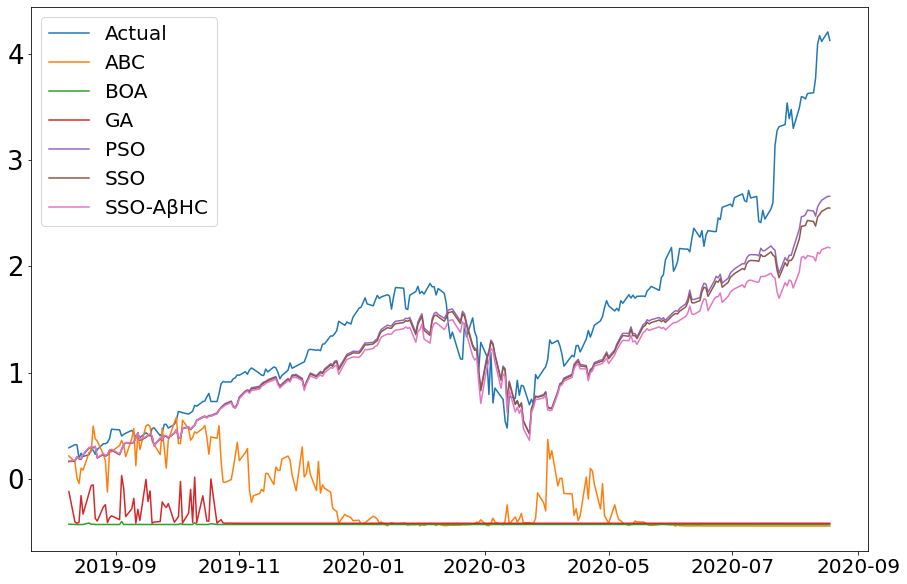

In [ ]:
figs,csave,comp = plot(c_list_1,g_list_1,com_1,results,opt,x_tests,y_tests)

In [ ]:
figs.savefig(comp +'_test_1.eps',format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
csave[0].to_excel(writer, sheet_name=comp +'_test_act')

In [ ]:
csave[1].to_excel(writer, sheet_name=comp +'_test_abc')

In [ ]:
csave[2].to_excel(writer, sheet_name=comp +'_test_boa')

In [ ]:
csave[3].to_excel(writer, sheet_name=comp +'_test_ga')

In [ ]:
csave[4].to_excel(writer, sheet_name=comp +'_test_pso')

In [ ]:
csave[5].to_excel(writer, sheet_name=comp +'_test_ssa')

In [ ]:
csave[6].to_excel(writer, sheet_name=comp +'_test_ssa-abhc')

In [ ]:
writer = pd.ExcelWriter(comp +'_whole_result_metadata.xlsx', engine='xlsxwriter')

In [ ]:
writer.save()

In [ ]:
writer = pd.ExcelWriter(comp +'_result_metadata.xlsx', engine='xlsxwriter')

In [ ]:
!pip install xlsxwriter

     |████████████████████████████████| 153kB 4.8MB/s 


In [ ]:
figs.savefig('tesla_whole_1.eps',format='eps', dpi=1200)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import collections

In [ ]:
def cal_mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
com_1 = 'EXXON MOBIL'
com_2 = 'TESLA'
com_3 = 'APPLE'
com_4 = 'ADOBE'

In [ ]:
r2 = collections.defaultdict(list)
mape = collections.defaultdict(list)
mae = collections.defaultdict(list)
opts_name = ['act','abc','boa','ga','pso','ssa','ssa-abhc']

In [ ]:
xls = pd.ExcelFile('result_metadata.xlsx')

In [ ]:
comp = com_4

In [ ]:
act = pd.read_excel(xls,comp +'_test_act')

In [ ]:
abc = pd.read_excel(xls,comp +'_test_abc')

In [ ]:
boa = pd.read_excel(xls,comp +'_test_boa')

In [ ]:
ga = pd.read_excel(xls,comp +'_test_ga')

In [ ]:
pso = pd.read_excel(xls,comp +'_test_pso')

In [ ]:
ssa = pd.read_excel(xls,comp +'_test_ssa')

In [ ]:
ssa_abhc = pd.read_excel(xls,comp +'_test_ssa-abhc')

In [ ]:
opts_file = [act,abc,boa,ga,pso,ssa,ssa_abhc]

In [ ]:
for i,opz in enumerate(opts_name):
  
  r2[opz].append(r2_score(opts_file[0]['Close'],opts_file[i]['Close']))
  mape[opz].append(cal_mape(opts_file[0]['Close'],opts_file[i]['Close']))
  mae[opz].append(mean_absolute_error(opts_file[0]['Close'],opts_file[i]['Close']))

In [ ]:
r2

defaultdict(list,
            {'abc': [-4.097749863371965,
              -4.487200988051602,
              -2.8530168232332804,
              -4.35973522547145],
             'act': [1.0, 1.0, 1.0, 1.0],
             'boa': [-4.636984471280107,
              -4.632511222802299,
              -4.504371531971643,
              -4.600768008834022],
             'ga': [-4.527121427344513,
              -4.501545560998191,
              -4.5025880216071235,
              -4.53739378498074],
             'pso': [0.7208030112232474,
              0.7209562066193014,
              0.6599427209569324,
              0.6128958186420794],
             'ssa': [0.6871013685054729,
              0.5375313021601715,
              0.5315934854070685,
              -0.0501490846449264],
             'ssa-abhc': [0.5583907405905844,
              0.7208024396668385,
              0.6496705241535374,
              -0.1344525394234084]})

In [ ]:
mape

defaultdict(list,
            {'abc': [101.77799239936449,
              116.08384153635079,
              72.78264961813512,
              109.97137702247686],
             'act': [0.0, 0.0, 0.0, 0.0],
             'boa': [144.02051472263068,
              143.86391493692233,
              129.89066720793653,
              142.37292835879515],
             'ga': [135.85447495815126,
              127.18430496544654,
              128.79723234366742,
              137.25793704231174],
             'pso': [21.745114147624545,
              21.746668898693493,
              23.10448366234668,
              24.305156854431857],
             'ssa': [22.65675749131008,
              26.246984671109434,
              26.402399082392662,
              34.900077679029714],
             'ssa-abhc': [24.864359607992366,
              21.76128194408887,
              23.37444559529115,
              36.944323930882454]})

In [ ]:
mae

defaultdict(list,
            {'abc': [1.656660124289764,
              1.7880092004629489,
              1.3061187556198248,
              1.7398126677651626],
             'act': [0.0, 0.0, 0.0, 0.0],
             'boa': [1.905193529857447,
              1.9041070652513987,
              1.8423671167227234,
              1.895303906161753],
             'ga': [1.8650056340202954,
              1.8327587462741948,
              1.8384367717501193,
              1.8708708292386769],
             'pso': [0.3403164064455122,
              0.34027512369718316,
              0.37267740676978,
              0.3975113792744939],
             'ssa': [0.3592391881145512,
              0.43554965024690384,
              0.438479880661519,
              0.6231654635118141],
             'ssa-abhc': [0.4151989756088855,
              0.3404640242384196,
              0.37822103645454175,
              0.6583693485335916]})

In [ ]:
r2 = pd.DataFrame(r2,index = [com_1,com_2,com_3,com_4])

In [ ]:
mape = pd.DataFrame(mape,index = [com_1,com_2,com_3,com_4])

In [ ]:
mae = pd.DataFrame(mae,index = [com_1,com_2,com_3,com_4])

In [ ]:
r2

,act,abc,boa,ga,pso,ssa,ssa-abhc
EXXON MOBIL,1.0,-4.097750,-4.636984,-4.527121,0.720803,0.687101,0.558391
TESLA,1.0,-4.487201,-4.632511,-4.501546,0.720956,0.537531,0.720802
APPLE,1.0,-2.853017,-4.504372,-4.502588,0.659943,0.531593,0.649671
ADOBE,1.0,-4.359735,-4.600768,-4.537394,0.612896,-0.050149,-0.134453


In [ ]:
mape

,act,abc,boa,ga,pso,ssa,ssa-abhc
EXXON MOBIL,0.0,101.777992,144.020515,135.854475,21.745114,22.656757,24.864360
TESLA,0.0,116.083842,143.863915,127.184305,21.746669,26.246985,21.761282
APPLE,0.0,72.782650,129.890667,128.797232,23.104484,26.402399,23.374446
ADOBE,0.0,109.971377,142.372928,137.257937,24.305157,34.900078,36.944324


In [ ]:
mae

,act,abc,boa,ga,pso,ssa,ssa-abhc
EXXON MOBIL,0.0,1.656660,1.905194,1.865006,0.340316,0.359239,0.415199
TESLA,0.0,1.788009,1.904107,1.832759,0.340275,0.435550,0.340464
APPLE,0.0,1.306119,1.842367,1.838437,0.372677,0.438480,0.378221
ADOBE,0.0,1.739813,1.895304,1.870871,0.397511,0.623165,0.658369


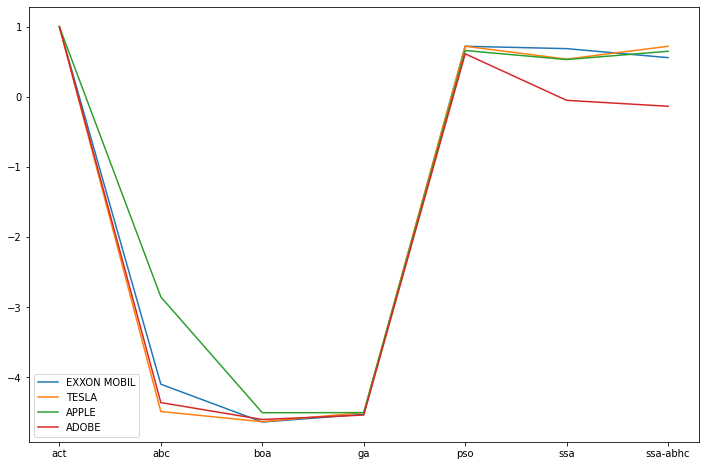

In [ ]:
r2.transpose().plot(figsize= (12,8))

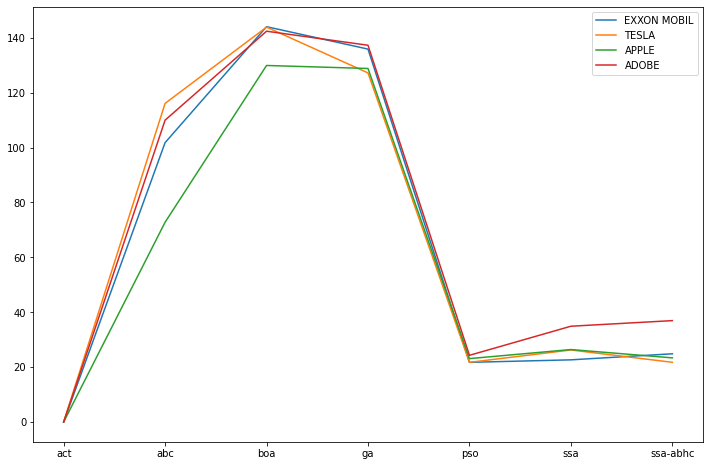

In [ ]:
mape.transpose().plot(figsize= (12,8))

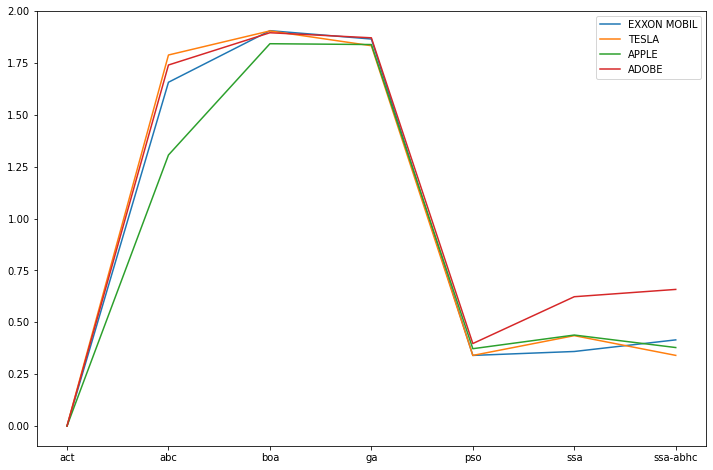

In [ ]:
mae.transpose().plot(figsize= (12,8))

In [ ]:
plt.rc('grid', color='w', linestyle='solid')